In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from functions import *
import numpy as np
import pandas as pd
import matplotlib
import os
import h5py
from scipy.constants import c, pi
import matplotlib.pyplot as plt

In [3]:
from numpy.fft import fftshift
from fft_module import *
import scipy

In [4]:
def fft(x):
    return scipy.fft(x.T).T

In [57]:
class Conversion_efficiency(object):

    def __init__(self, freq_band, possition, filename=None, filepath='',filename2 = 'CE',filepath2 = 'output_final/'):
        self.variables = ('P_p', 'P_s', 'f_p', 'f_s','l_p','l_s,' 'P_out', 'P_bef','CE','rounds')
        
        self.spec, self.fv, self.t, self.P0_p, self.P0_s,self.f_p, self.f_s, self.P_bef,self.ro,U_large,tt =\
            self.load_spectrum('0',filename, filepath)
        self.P_max = np.max(w2dbm(self.spec))
        
        self.spec, self.fv, self.t, self.P0_p, self.P0_s,self.f_p, self.f_s, self.P_bef,self.ro,U_large,tt =\
            self.load_spectrum(possition,filename, filepath)
        self.tt = tt
       
    
        #self.U = np.zeros(np.shape(U_large),dtype = np.complex)
        

        #for i in range(np.shape(self.U)[0]):
        #    self.U[i,:] = U_large[i][:]
        
        self.spec = self.spec[:,0]
        #self.spec = np.mean(np.abs(self.U[100:,:])**2, axis = 0)
        
        
        self.U_large = U_large
        self.nt = np.shape(self.spec)[0]
        fv_id = self.pos_of_idler()
        self.fv_id = fv_id
        self.start, self.end= self.fv[fv_id] - freq_band, self.fv[fv_id] + freq_band
        self.P_in = self.P0_p + self.P0_s
        #self.P_out = self.calc_P_out()
        
        P_out_vec = []
        for i in U_large[100:][:]:
            self.spec = np.abs(i)**2
            P_out_vec.append(self.calc_P_out())
        
        self.P_out = np.mean(P_out_vec)
        self.CE = self.calc_CE()

        self.std = { i : None for i in ('P_p', 'P_s', 'f_p', 'f_s','l_p','l_s,' 'P_out', 'P_bef','CE','rounds')}
        self.std['P_out'] = np.std(P_out_vec)
        self.std['CE'] = self.std['P_out']/self.P_in
        
        self.read_write_CE_table(filename2,var = None, P_p = self.P0_p, P_s = self.P0_s, f_p = self.f_p,
                                         f_s = self.f_s,P_out = self.P_out,P_bef = self.P_bef, CE = self.CE, var2 = 'CE',std = self.std,file_path=filepath2)
        
        lami = 1e-3*c/self.fv[fv_id]
        self.lami = lami
        self.lamp = 1e-3*c/self.f_p
        self.spec_s = -self.P_max + w2dbm(self.spec)
        return None

    
    def pos_of_idler(self):
        plom = self.nt//2+10
        fv_id = np.where(self.spec[plom:] == np.max(self.spec[plom:]))[0][0]
        fv_id += plom
        return fv_id
    
    
    def load_spectrum(self, possition,filename='data_large', filepath=''):
        with h5py.File(filepath+filename+'.hdf5','r') as f: 
            l = f.get(possition)
            U_large = ()
            for i in l.keys():
                steady_state = i 
                layers = possition + '/' + steady_state
                D = read_variables(filename,layers, filepath)
                U = D['U']
                U_large += (U[:,0],)
            fv = D['fv']
            ro = D['ro']

            Uabs = np.real(D['Uabs'])
            P0_s = D['P0_s']
            P0_p = D['P0_p']
            t = D['t']
            f_p = D['f_p']
            f_s = D['f_s']
            layers = '1/0'
            
            D = read_variables(filename,layers, filepath)
            Uabss = dbm2w(np.real(D['Uabs']))
            fvs = D['fv']
            tt = D['t']

            P_bef = simps(Uabss[:,0],fvs)
            P_bef /= 2*np.max(tt)
        return dbm2w(Uabs), fv,t, P0_p, P0_s, f_p, f_s,P_bef, ro, U_large,t



    def calc_P_out(self):
        i = np.where(
            np.abs(self.fv - self.start) == np.min(np.abs(self.fv - self.start)))[0][0]
        j = np.where(
            np.abs(self.fv - self.end) == np.min(np.abs(self.fv - self.end)))[0][0]
        E_out = simps(self.spec[i:j], self.fv[i:j])
        P_out = E_out/(2*np.max(self.tt))
        #print(P_out)
        return P_out   


    def calc_CE(self):
        CE = 100*self.P_out/self.P_in
        return CE


    def read_write_CE_table(self,filename,var = None, P_p = None, P_s = None, f_p = None, f_s = None,P_out = None, P_bef = None,CE = None, var2 = 'CE',std = None,file_path=''):
        
        """ Given values of the parameters this function uses pandas to open an
            hdf5 file and append to the dataframe there. It also returns the full data
            for post-processing. 
            
            It returns a tuple of 2 numpy arrays the first with the variable var and the second with
            the conversion efficiencty (as default). If no input is given( default then it just reads the )
        """
        try:
            l_s = 1e-3*c/f_s
        except TypeError:
            l_s = None
            pass
        try:
            l_p = 1e-3*c/f_p
        except TypeError:
            l_p = None
            pass
        A = np.array([P_p, P_s, f_p, f_s,l_s,l_p, P_out, P_bef, CE]).T
        a = pd.DataFrame(A, index = ['P_p', 'P_s','f_p', 'f_s','l_s','l_p', 'P_out','P_bef', 'CE']).T
        try:
            ab = pd.read_hdf(file_path+filename+'.hdf5')
            if not(A.any() == None):
                ab = ab.append(a, ignore_index=True)
        except IOError:
            if not(A.any() == None):
                ab = a
            else: 
                sys.exit("There is no data in file or given")
            pass
        store = ab.to_hdf(file_path+filename+'.hdf5',key='a')
        b = pd.DataFrame.from_dict([std])
        try:
            ba = pd.read_hdf(file_path+filename+'_std.hdf5', key = 'b')
            if not(A.any() == None):
                ba = ba.append(b, ignore_index=True)
        except IOError:
            if not(A.any() == None):
                ba = b
            else: 
                sys.exit("There is no data in file or given")
            pass
        store2 = ba.to_hdf(file_path+filename+'_std.hdf5', key = 'b')

        if var is None:
            return None
        else:
            return ab[var].as_matrix(),ab[var2].as_matrix(),ba


    def plot_CE(self,var,var2 = 'CE',filename = 'CE', filepath='output_final/', filesave= None):
        var_val, CE,std = self.read_write_CE_table(filename,var,var2 = var2,file_path=filepath)
        std = std[var2].as_matrix()
        print(np.shape(std), np.shape(CE))
        fig = plt.figure(figsize=(20.0, 10.0))
        plt.errorbar(var_val, CE, yerr=std, capsize= 10)
        plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel(var)
        plt.ylabel(var2)
        plt.savefig(filesave+'.png',bbox_inches = 'tight')
    
           
        #plt.close(fig)
        return None


In [68]:
def contor_plot(fmin,fmax,CE,rounds = None,filename = None):
    
    
    i = np.where(np.abs(CE.fv - fmin) == np.min(np.abs(CE.fv - fmin)))[0][0]
    j = np.where(np.abs(CE.fv - fmax) == np.min(np.abs(CE.fv - fmax)))[0][0]
    U = np.asanyarray(CE.U_large)
    if rounds is None:
        rounds = np.shape(U)[0]
   
    CE.ro = range(rounds)
    x,y = np.meshgrid(CE.ro, CE.fv[i:j])
    z = w2dbm(np.abs(U.T[i:j,:rounds])**2)
    low_values_indices = z < -5  # Where values are low
    z[low_values_indices] = -5  # All low values set to 0
    fig = plt.figure(figsize=(20,10))
    plt.contourf(x,y, z,100)
    plt.xlabel(r'$rounds$')
    plt.ylabel(r'$f(THz)$')
    plt.colorbar()
    if filename is not None:
        plt.savefig(str(filename), bbox_inches = 'tight')
        plt.close('all')
    else:
        plt.show()
    return None

In [69]:
#which = 'output_dump_pump_wavelengths'
#which ='output_dump_pump_powers/ram0ss0'
#which = 'output_dump_pump_powers/large'
which = 'output_dump_pump_powers/large'

In [70]:
os.system('rm output_final/CE.hdf5 output_final/CE_std.hdf5')

0

In [71]:
%matplotlib inline
os.system('rm output_final/CE.hdf5 output_final/CE_std.hdf5')
lami_vec = []
lamp_vec = []
specs_large = []
for i in range(30):
    CE = Conversion_efficiency(5,possition = 'portB', filename = 'data_large',filepath = which+'/output'+str(i)+'/data/')


    fmin,fmax,rounds  = (np.min(CE.fv)+np.max(CE.fv))/2 +10,np.max(CE.fv) - 100,None
    #fmin,fmax,rounds = np.min(CE.fv) + 100, (np.min(CE.fv)+np.max(CE.fv))/2 -1,None
    #print(fmin,fmax)
    #sys.exit()
    lami_vec.append(CE.lami)
    specs_large.append(CE.spec_s)
    #plt.show()
    lamp_vec.append(CE.lamp)
    #fmin,fmax,rounds  = 317,320, None
    contor_plot(fmin,fmax,CE,rounds,filename= str(i))
    

/home/john/miniconda3/lib/python3.5/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['P_bef', 'P_p', 'P_s', 'f_p', 'f_s', 'l_p', 'l_s,P_out', 'rounds']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


/home/john/miniconda3/lib/python3.5/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['P_bef', 'P_p', 'P_s', 'f_p', 'f_s', 'l_p', 'l_s,P_out', 'rounds']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


(30,) (30,)
(30,) (30,)


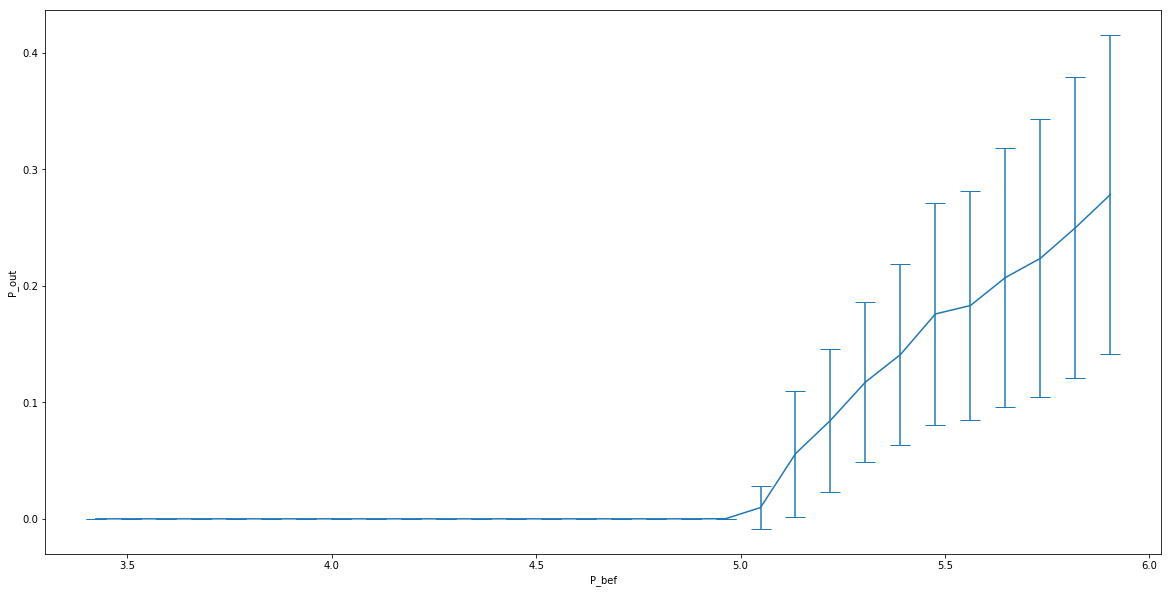

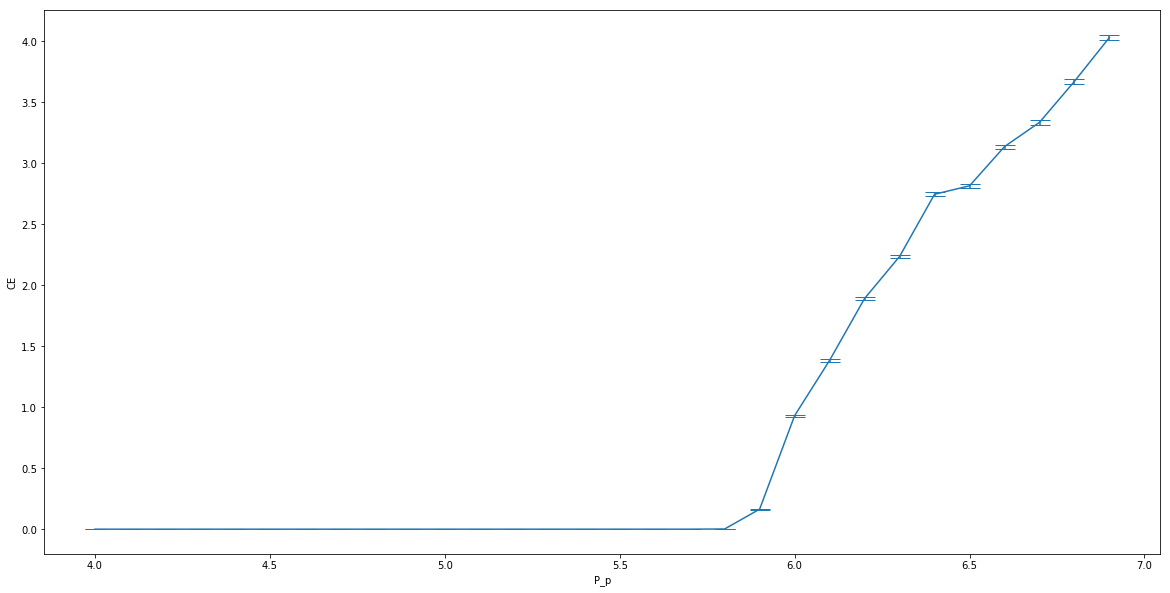

In [72]:
var1, var2 = 'P_bef', 'P_out'
for var1,var2 in (('P_bef', 'P_out'), ('P_p', 'CE')):
    CE.plot_CE(var1, var2,filesave = 'large')

/home/john/miniconda3/lib/python3.5/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['P_bef', 'P_p', 'P_s', 'f_p', 'f_s', 'l_p', 'l_s,P_out', 'rounds']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


(30,) (30,)
(30,) (30,)


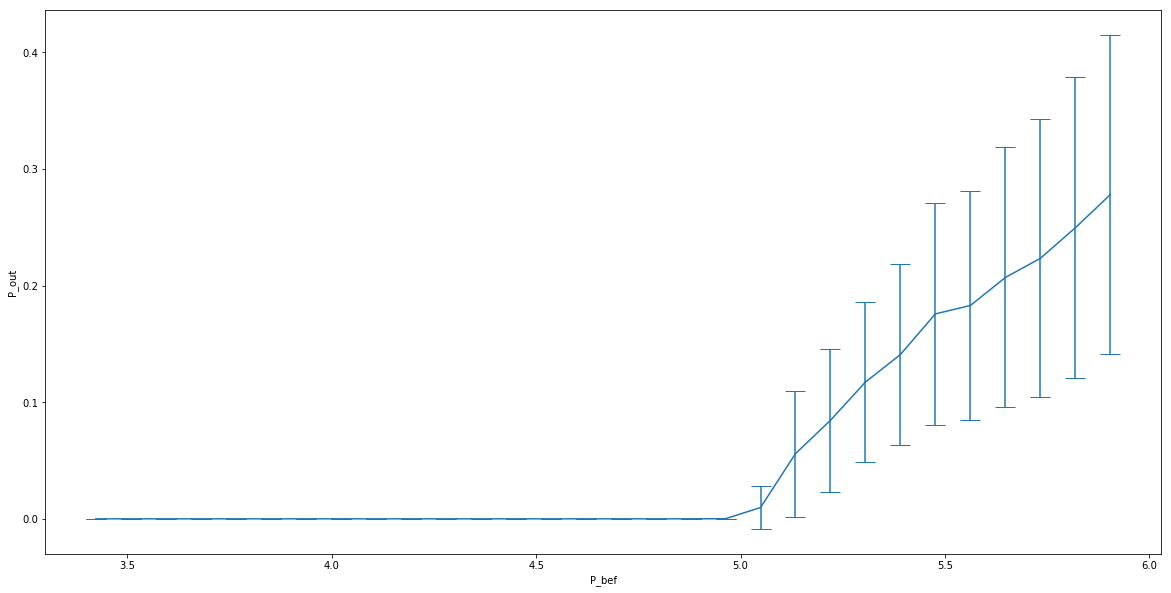

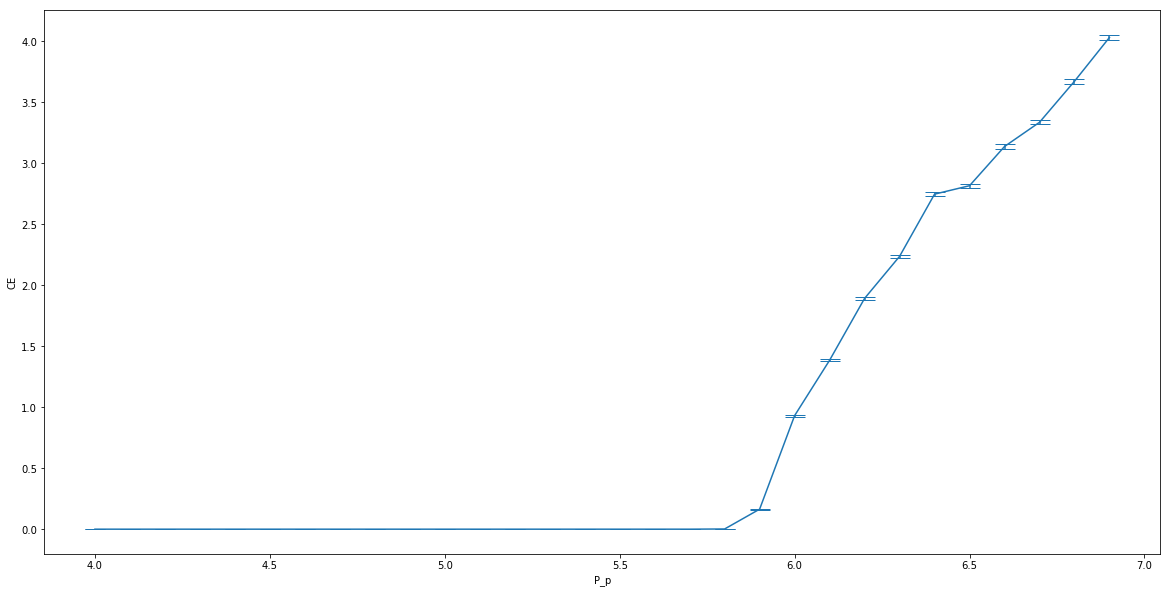

In [30]:
var1, var2 = 'P_bef', 'P_out'
for var1,var2 in (('P_bef', 'P_out'), ('P_p', 'CE')):
    CE.plot_CE(var1, var2,filesave = 'large')

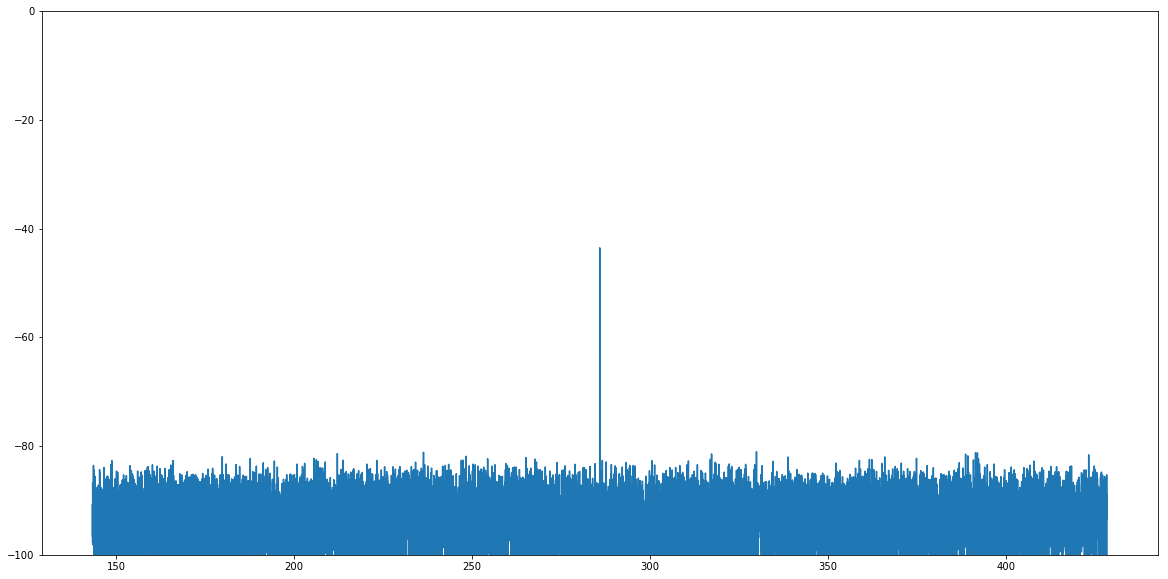

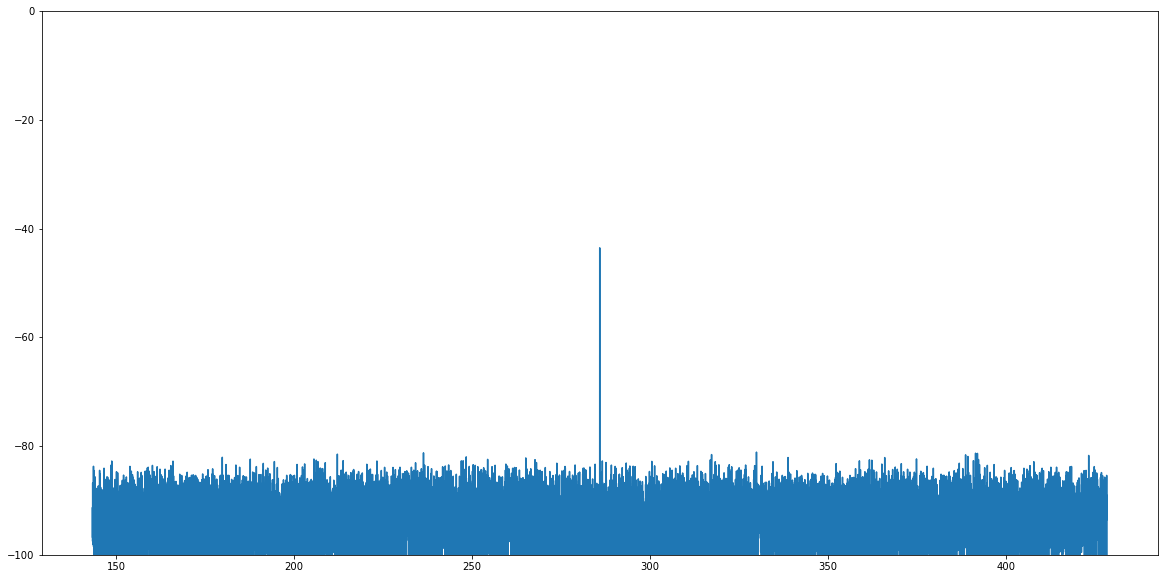

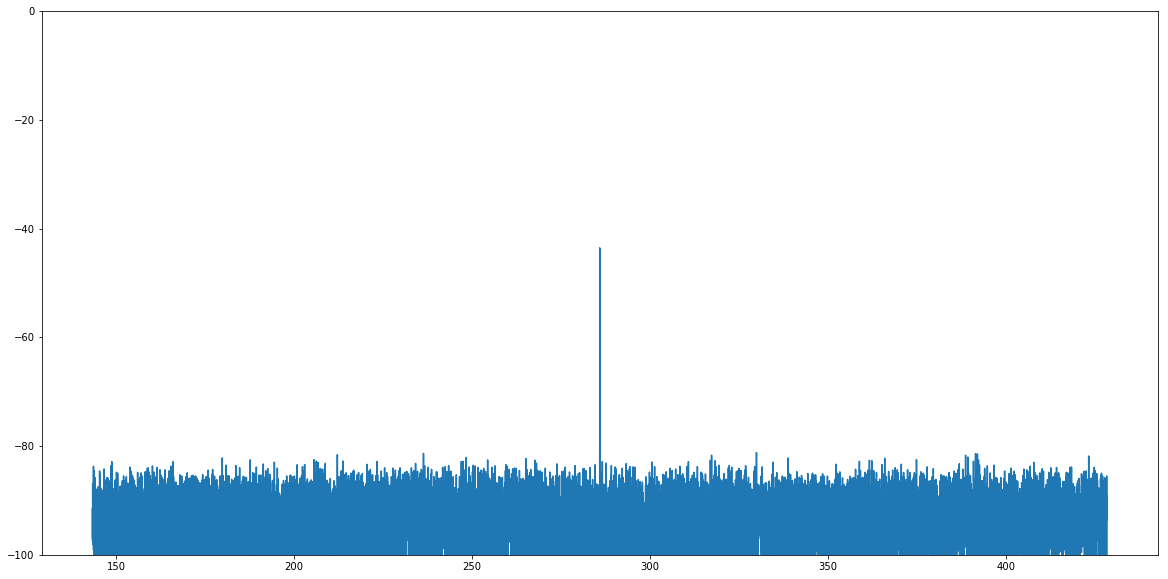

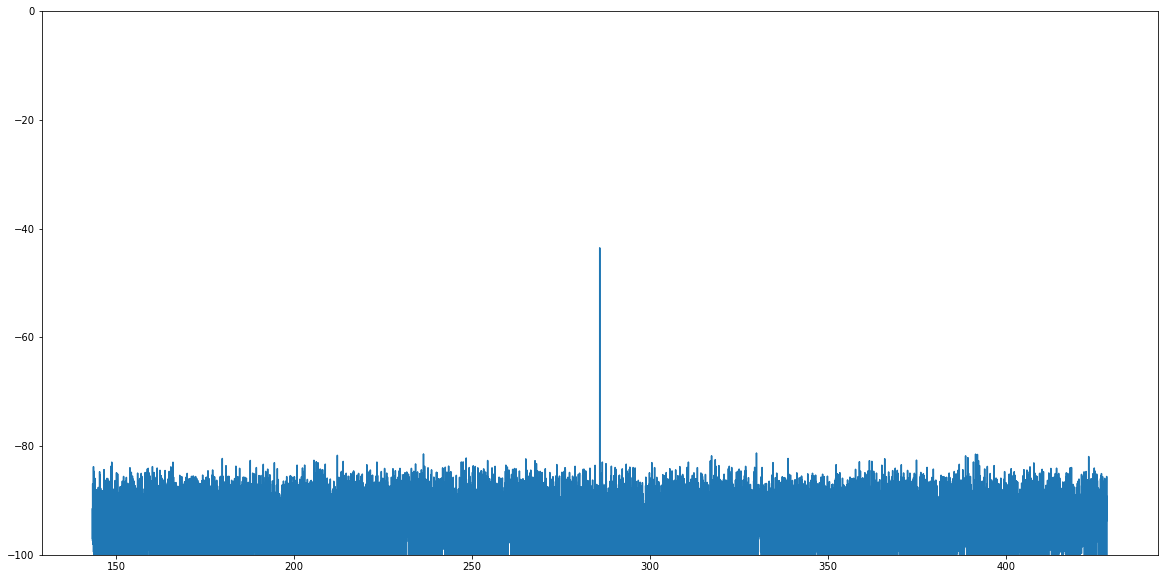

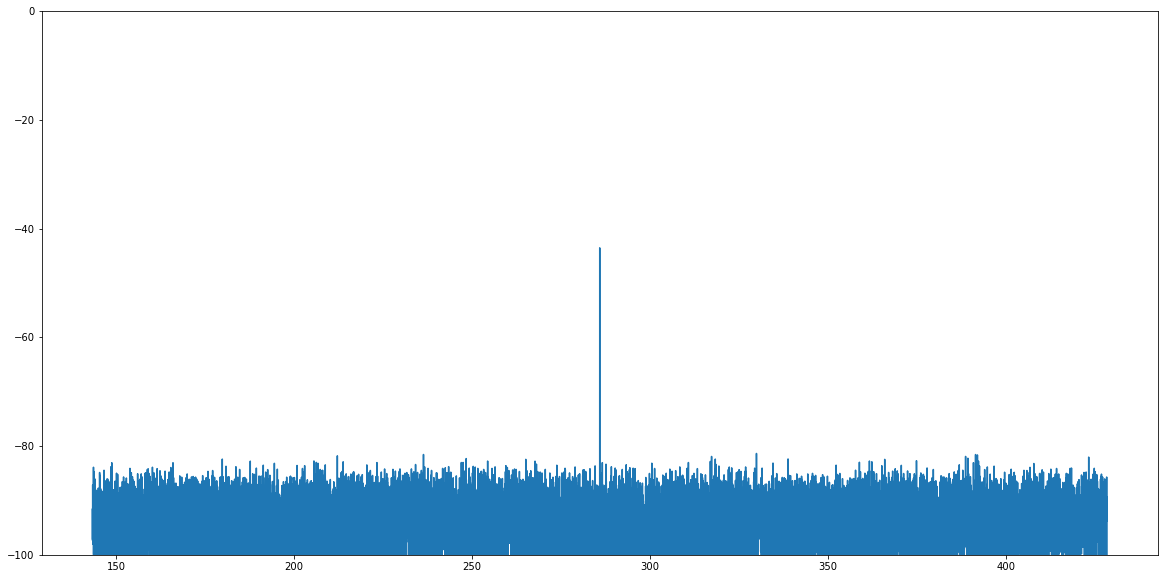

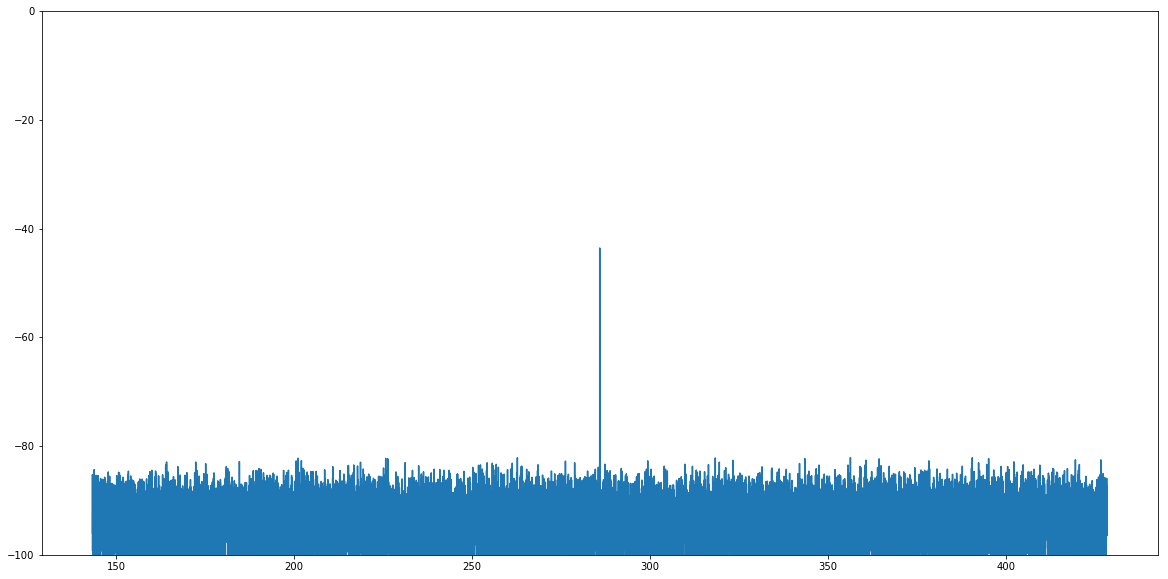

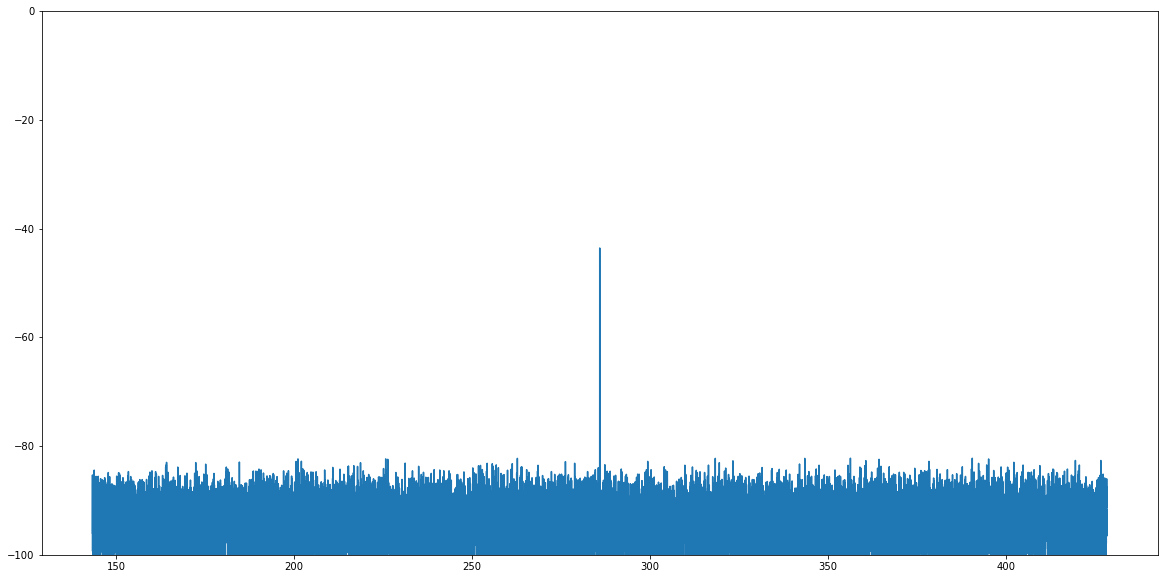

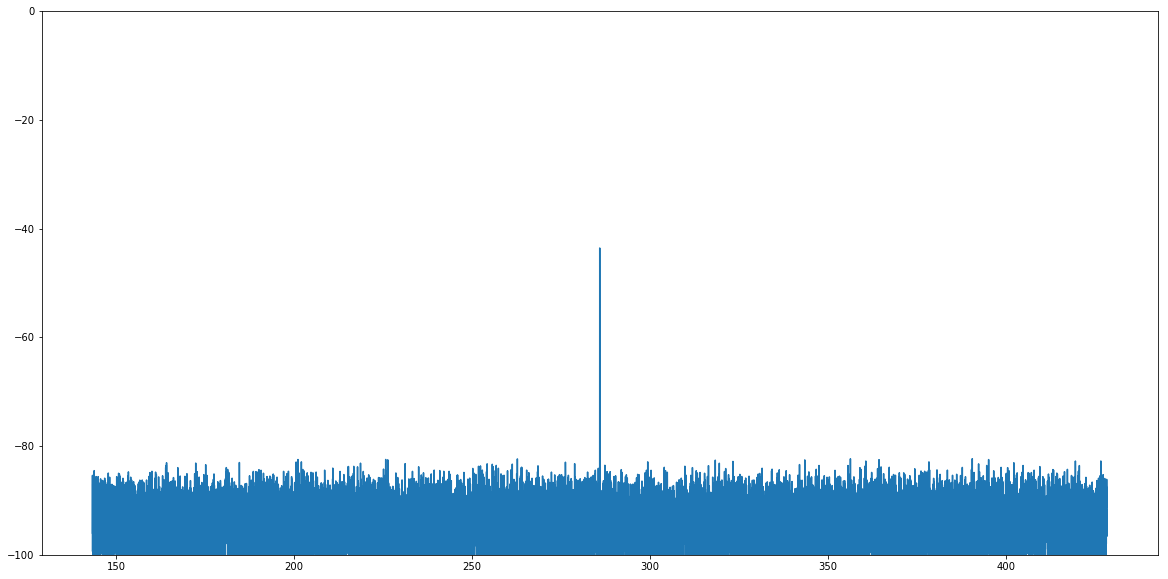

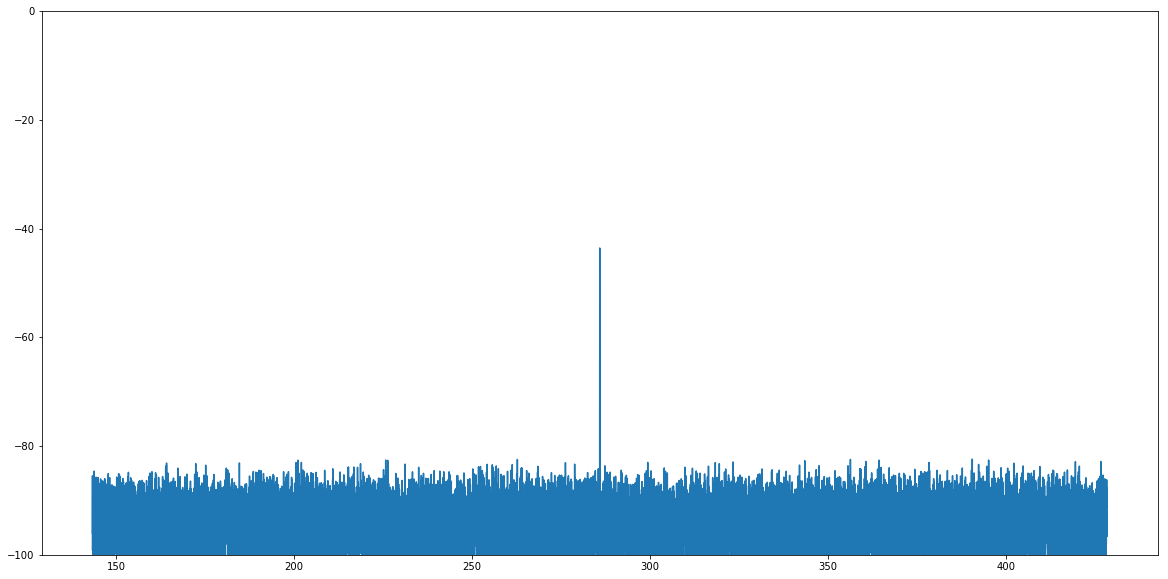

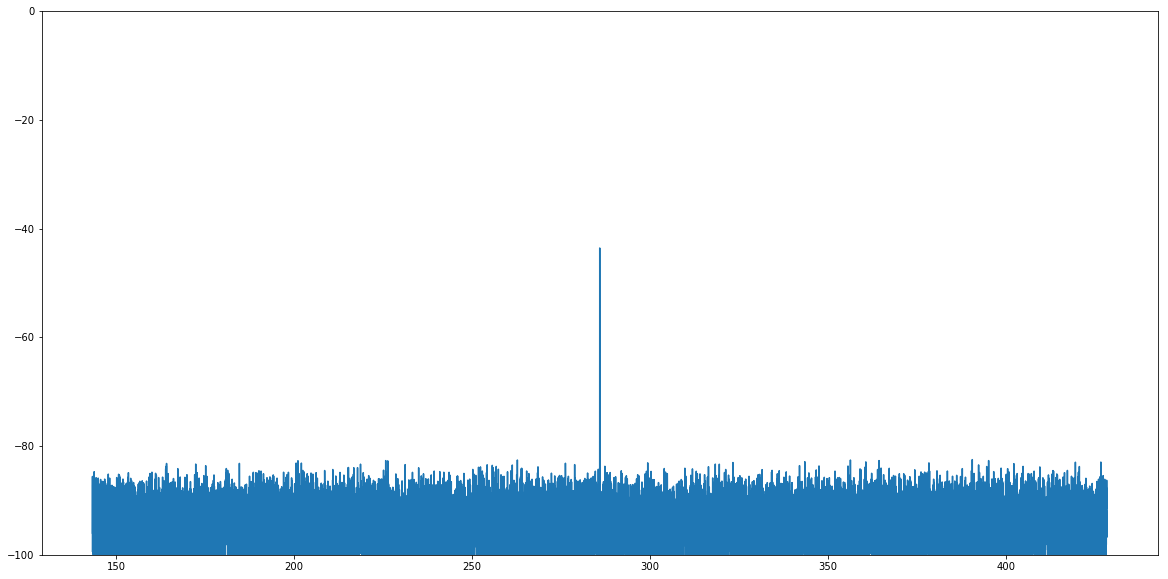

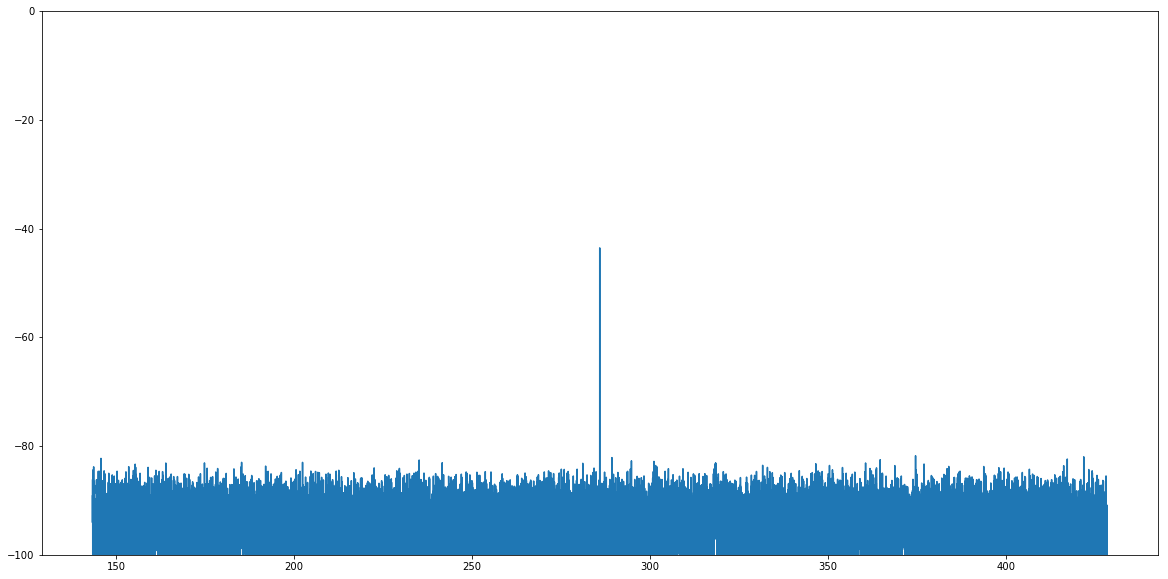

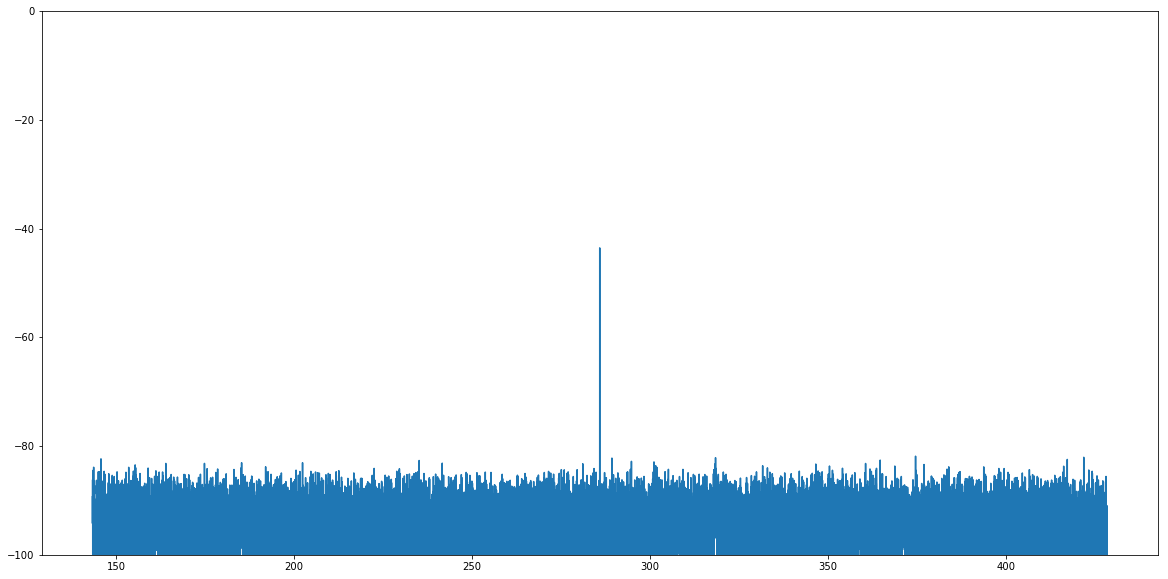

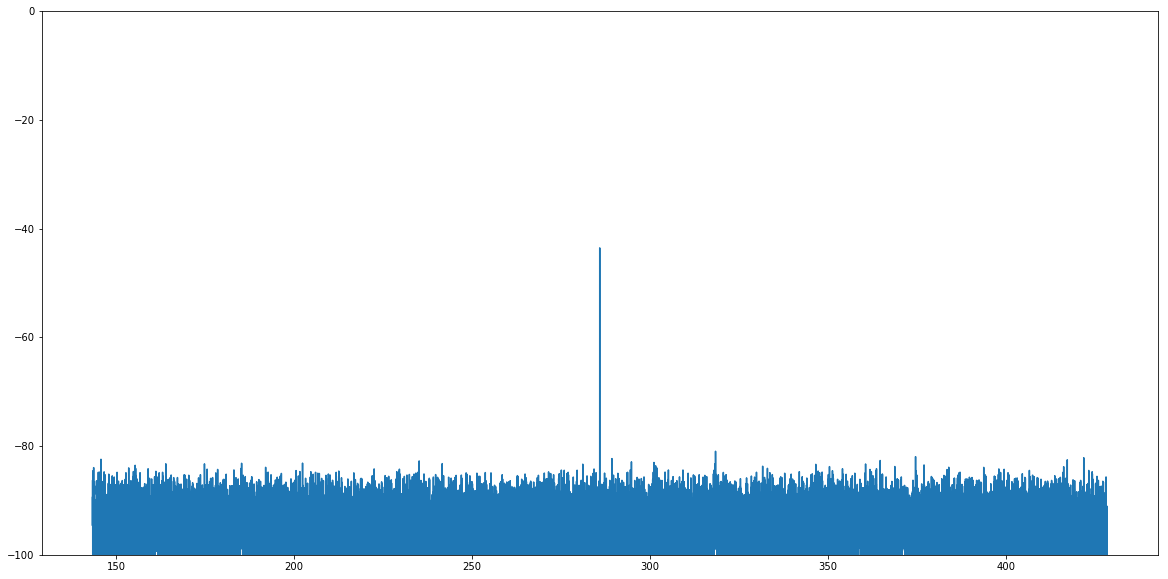

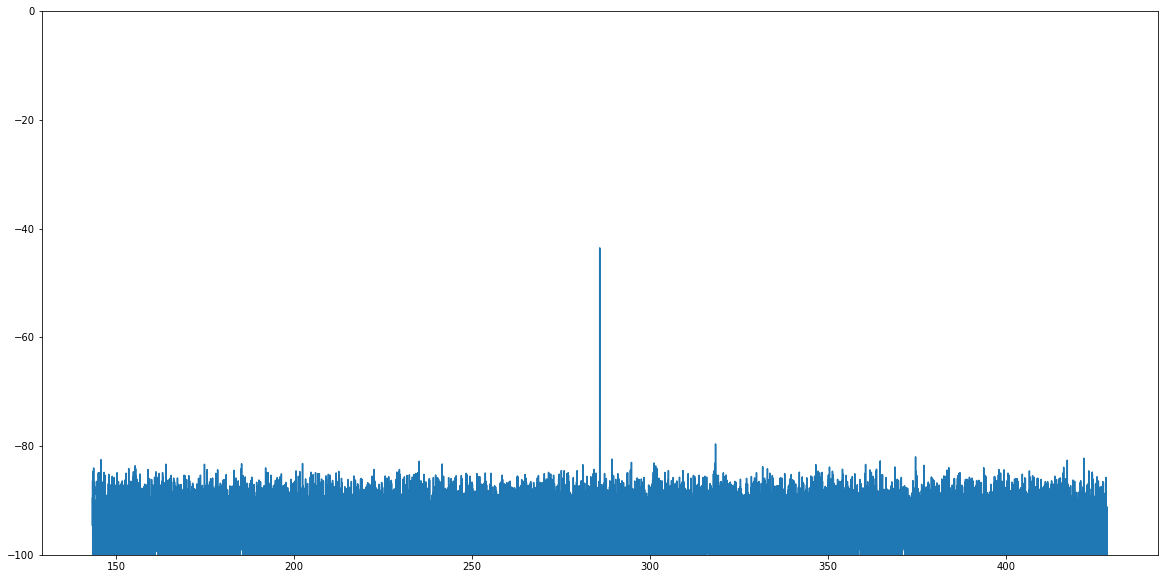

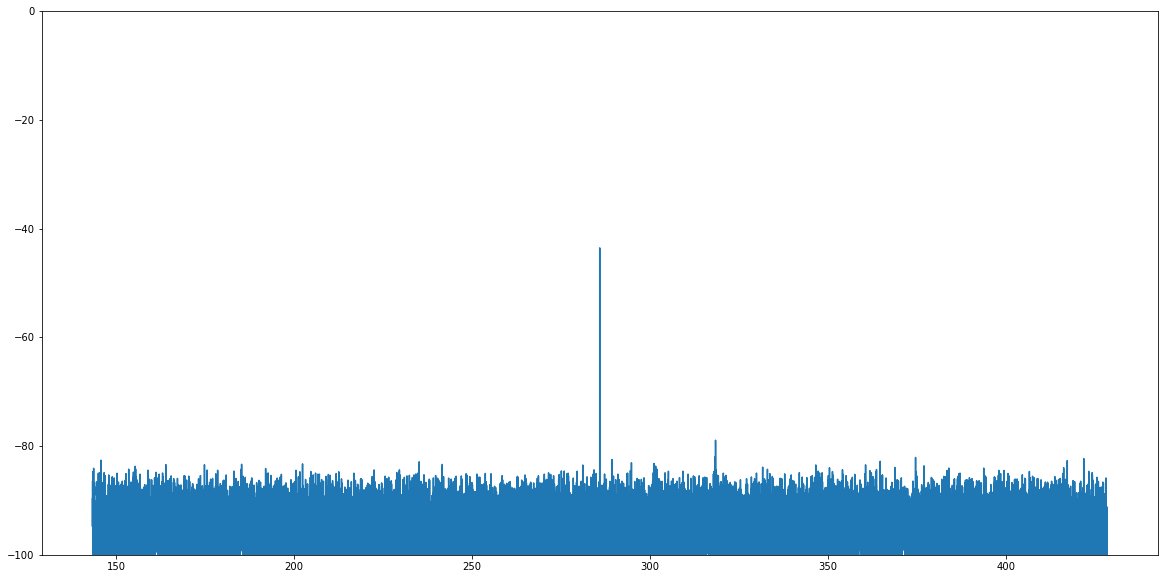

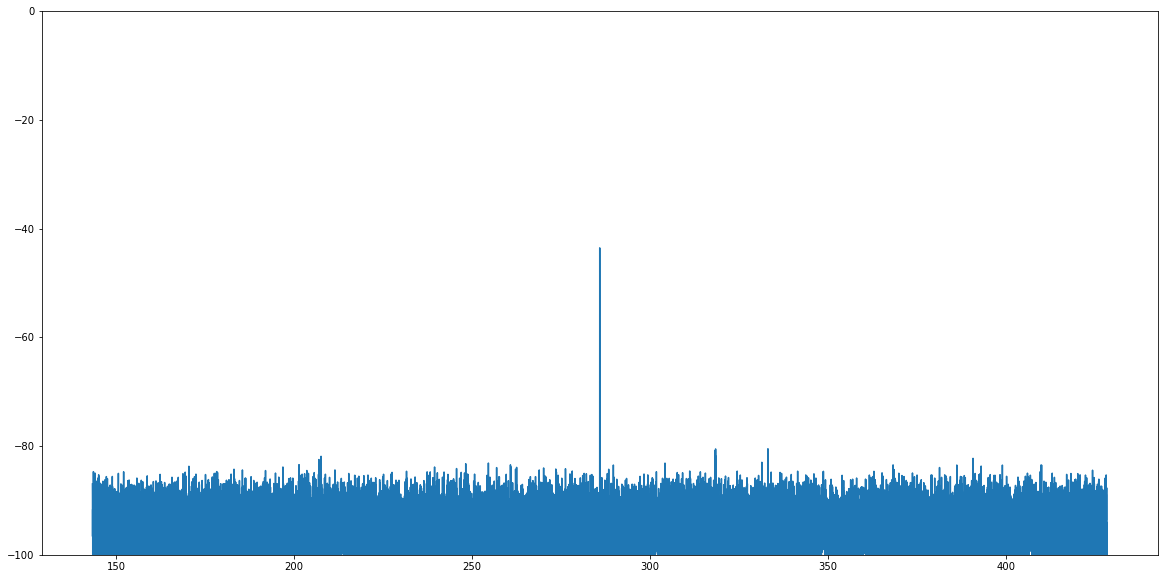

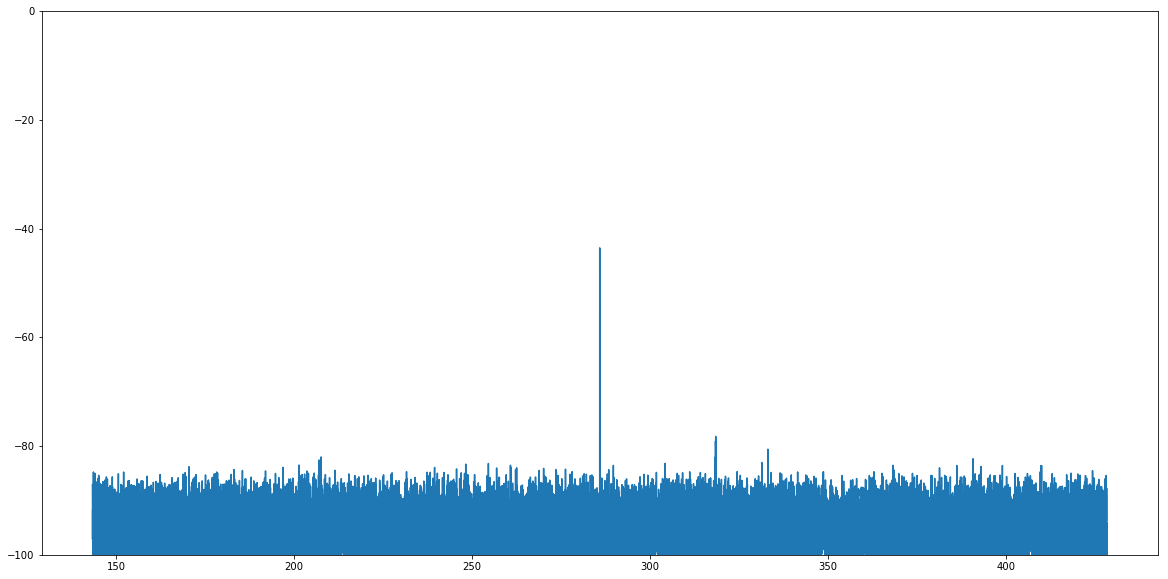

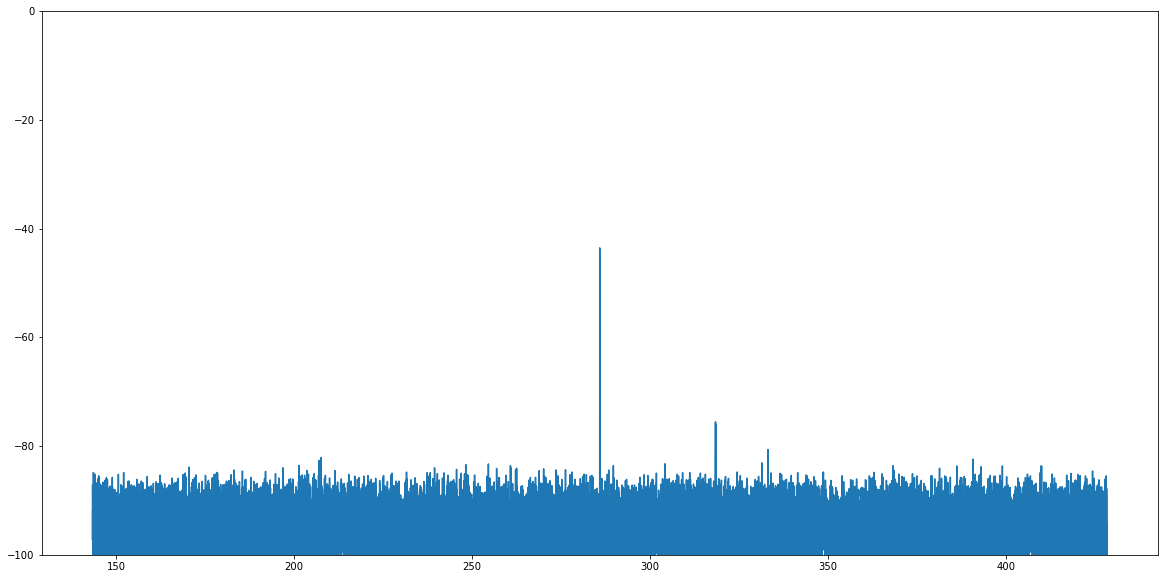

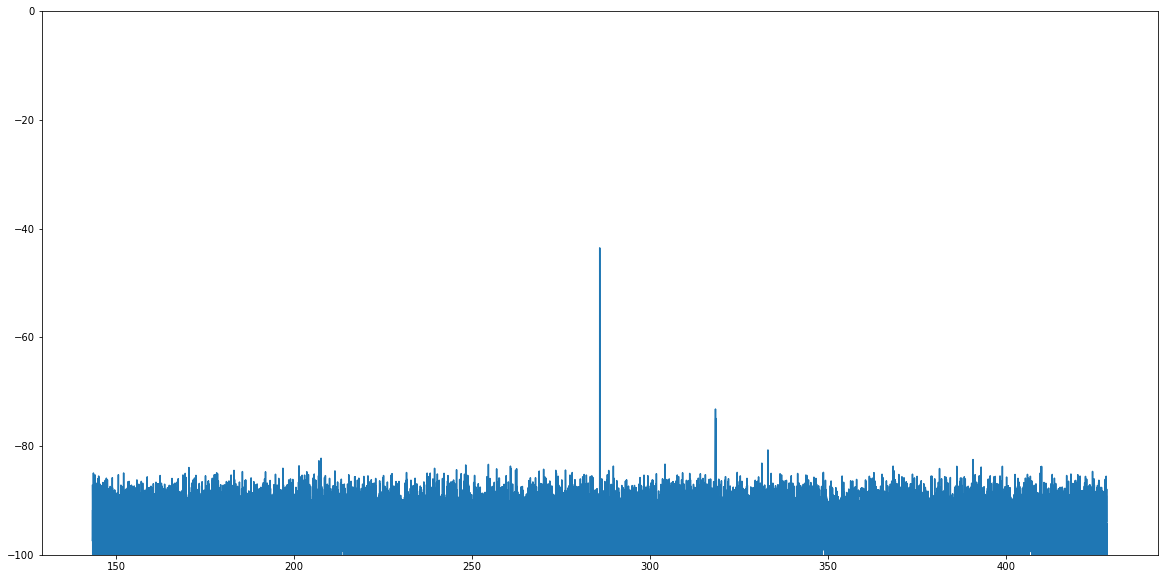

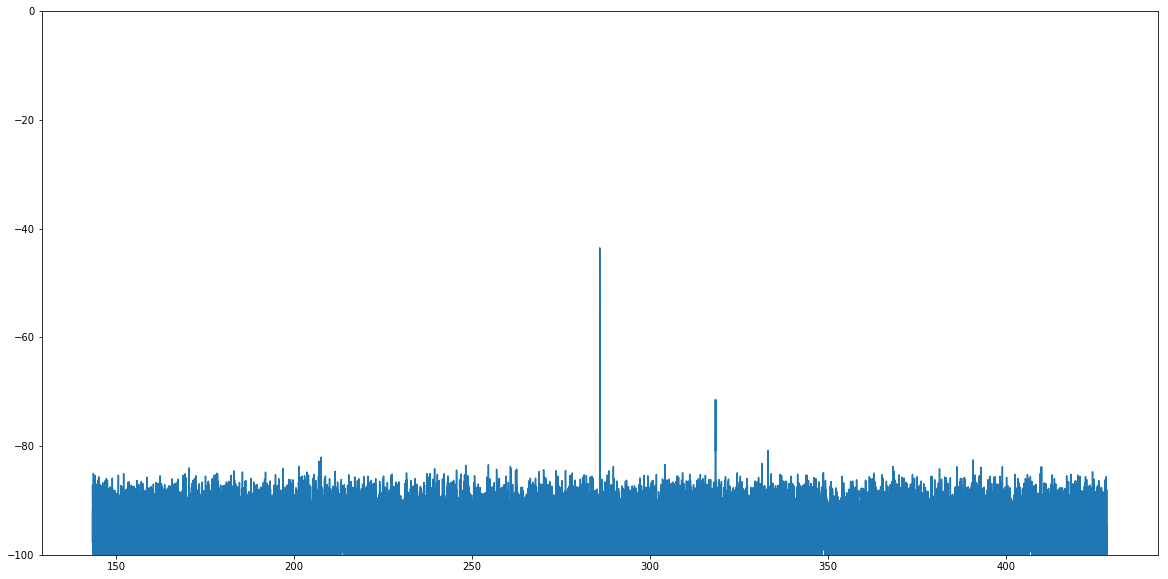

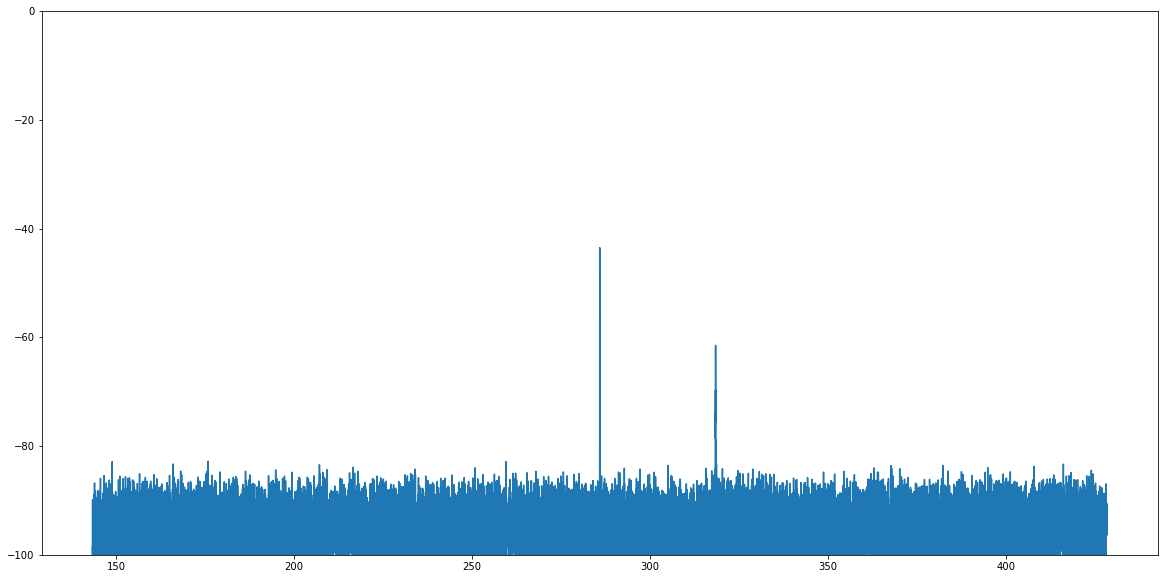

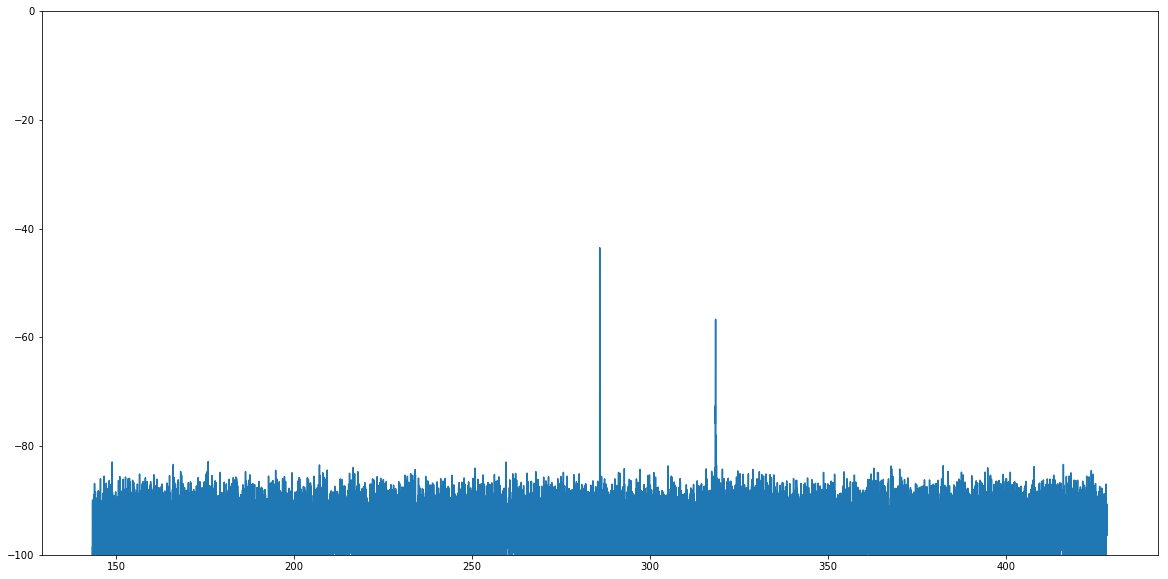

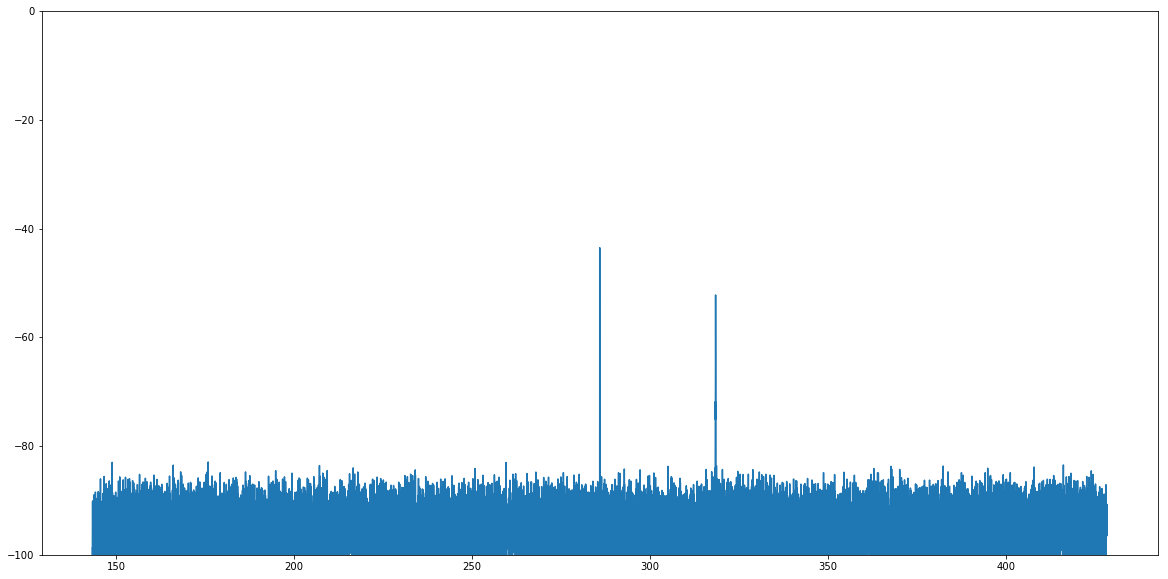

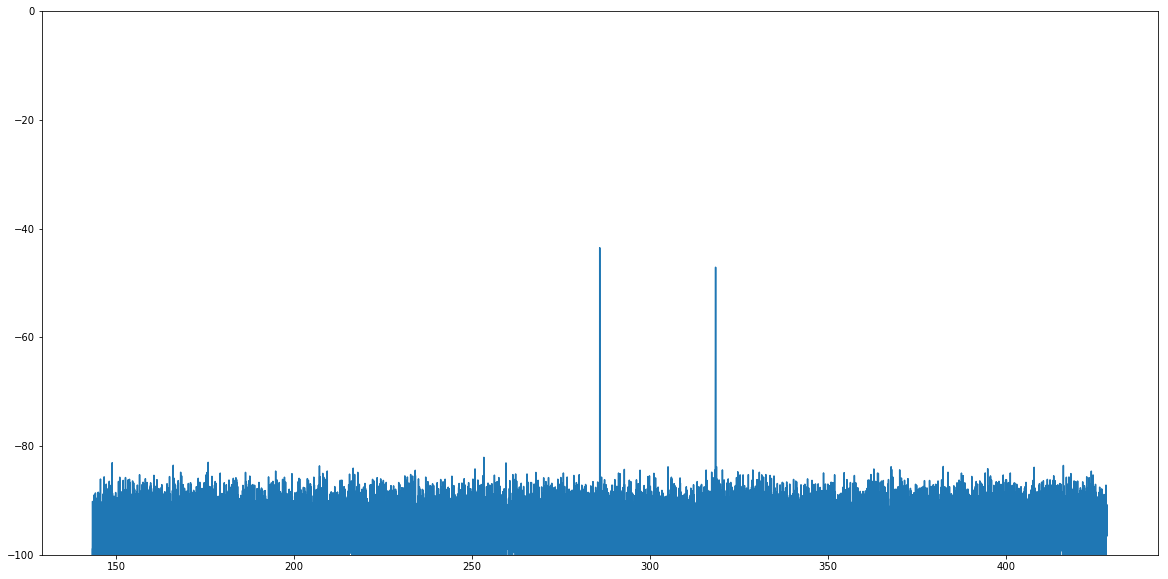

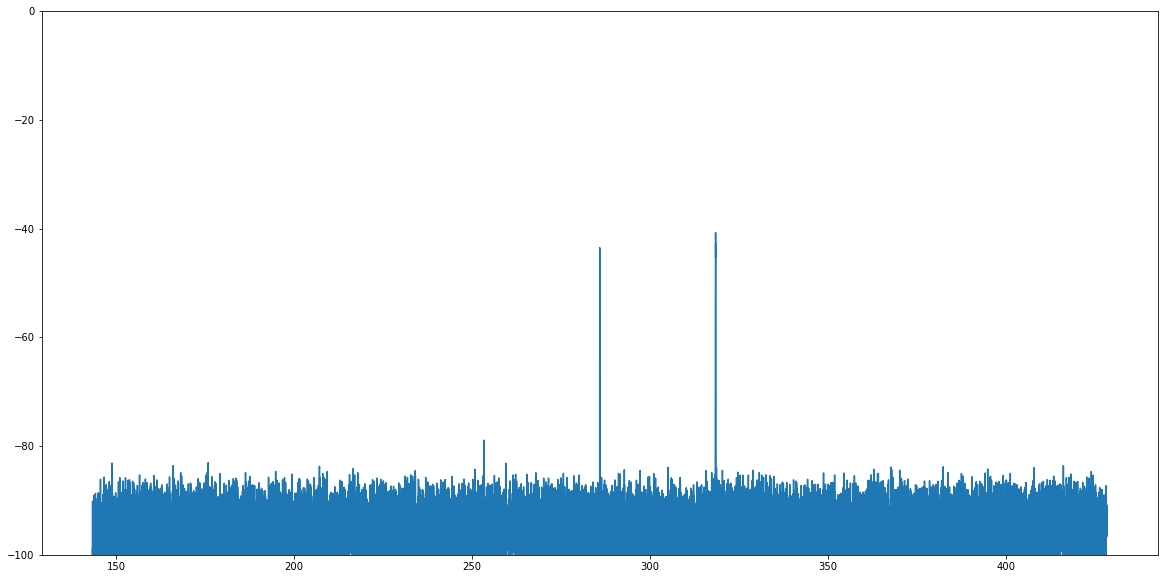

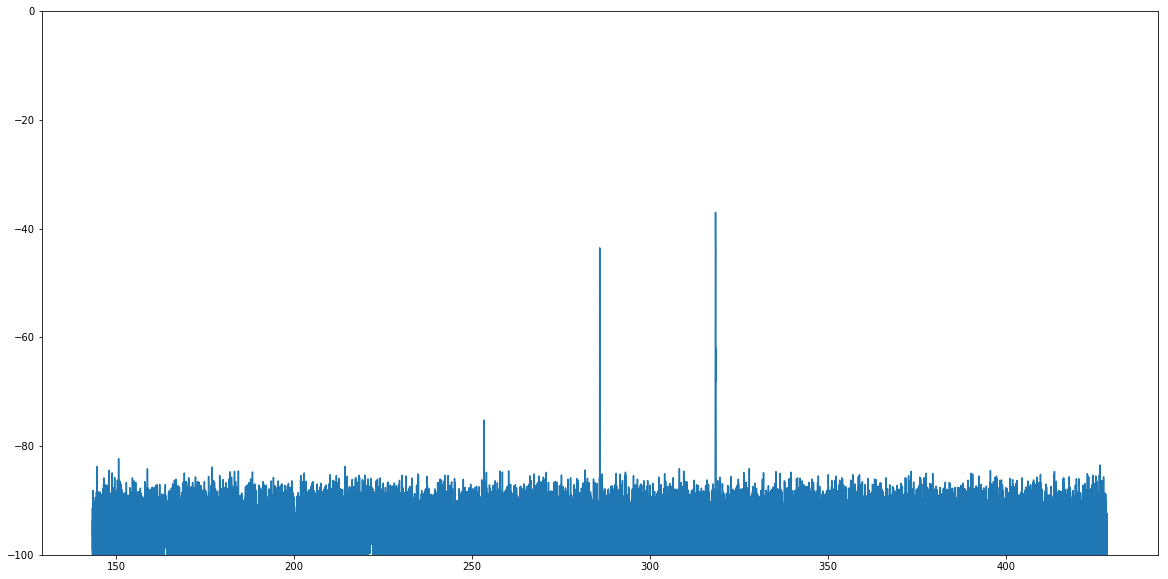

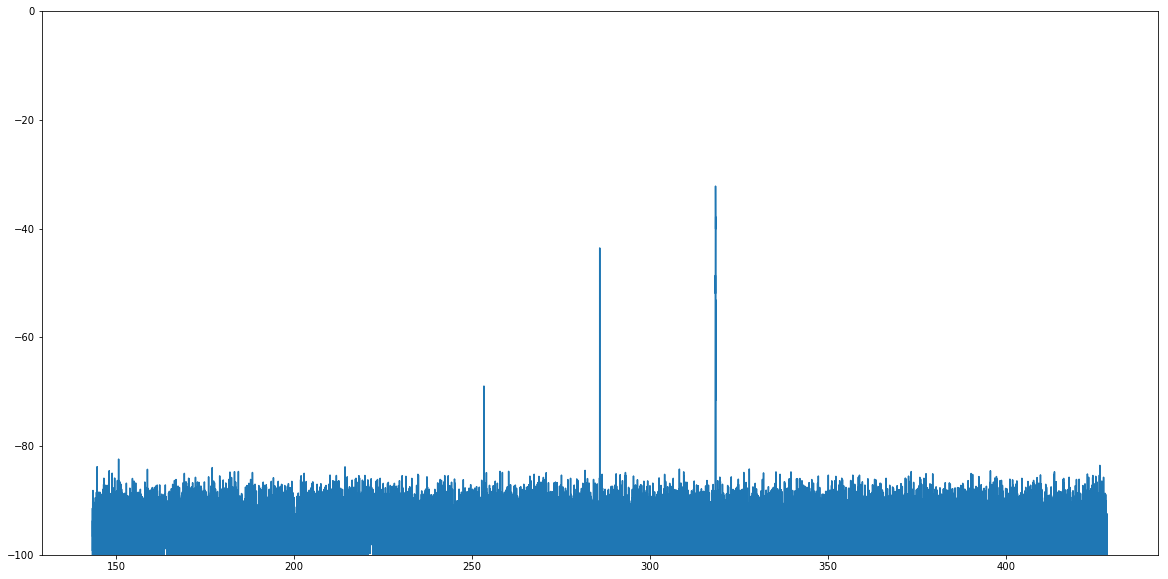

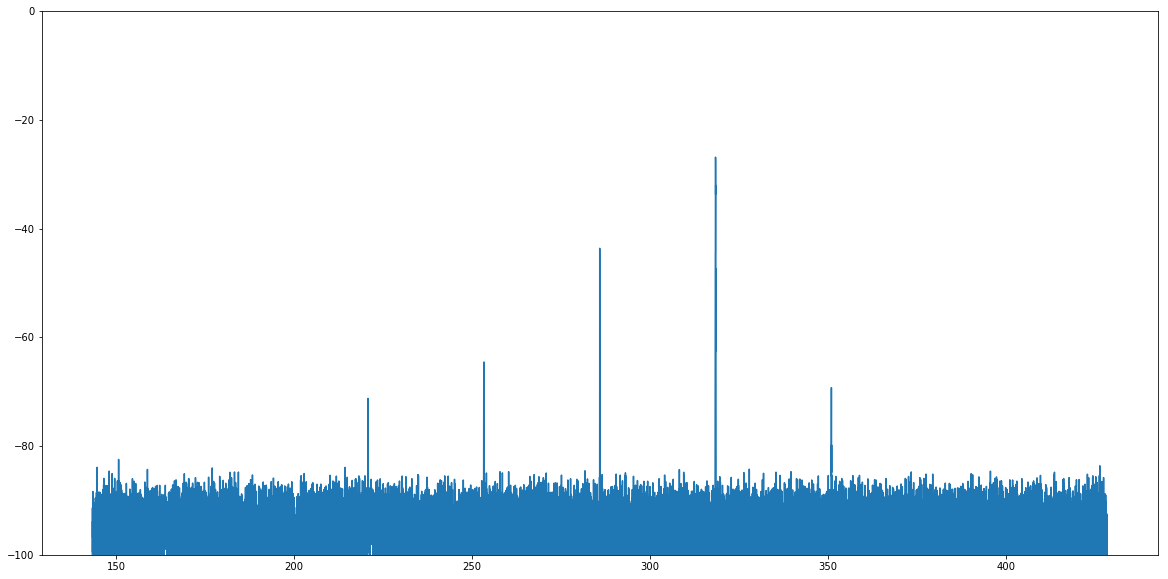

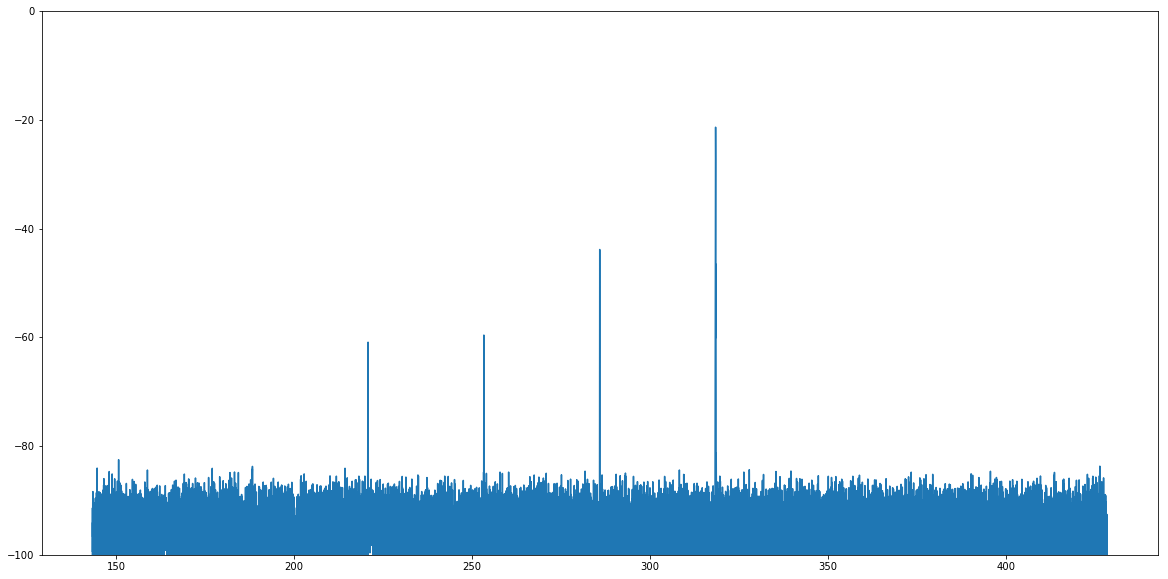

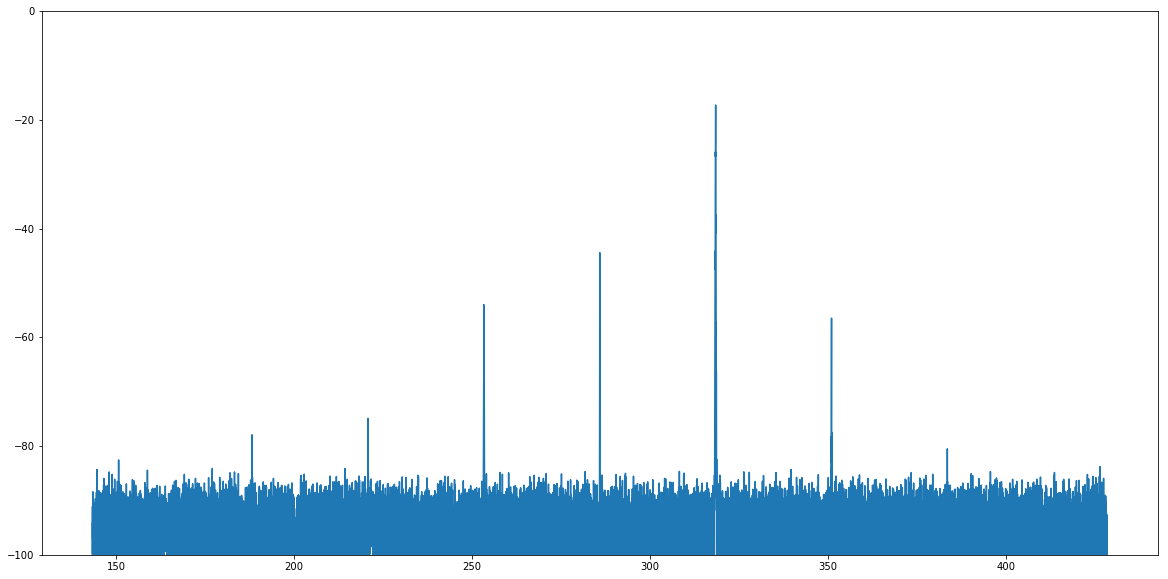

In [31]:
#%matplotlib notebook

for i in specs_large:
    fig = plt.figure(figsize=(20,10))
    plt.plot(CE.fv, i)
    #plt.xlim(900,1250)
    plt.ylim(-100,0)
    plt.show()
    #break